In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Mounted my drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/dl4e
# %mkdir dl4e
# %cd dl4e

/content/drive/MyDrive/dl4e


In [ ]:
%ls -l

total 4055418
-rw------- 1 root root       4125 Feb 14 21:46 AnnotationReader.py
drwx------ 2 root root       4096 Feb 17 21:20 Annotations/
drwx------ 2 root root       4096 Feb 14 18:00 Audio/
-rw------- 1 root root       4510 Feb 14 21:46 Code.zip
drwx------ 2 root root       4096 Feb 17 20:04 DataFiles/
-rw------- 1 root root 2068190524 Feb 15 10:38 Data.zip
-rw------- 1 root root 2084499796 Feb 18 07:41 history_model_1.pkl
drwx------ 5 root root       4096 Feb 14 18:00 __MACOSX/
drwx------ 2 root root       4096 Feb 14 18:52 Model_Output/
-rw------- 1 root root        176 Feb 18 05:28 params.json
drwx------ 2 root root       4096 Feb 14 18:53 Pickled_Data/
-rw------- 1 root root      10668 Feb 17 15:35 Preprocessing.py
drwx------ 2 root root       4096 Feb 14 18:54 __pycache__/
drwx------ 2 root root       4096 Feb 14 18:53 Saved_Data/
drwx------ 9 root root       4096 Feb 14 18:03 scikit-maad/


## Installation and Importation

This action requires AIMS email. Be sure that, try to run it with your AIMS email adress.

In [ ]:
# You might need to restart the runtime after running this code. You'll only
# have to do this once per runtime. Once you restart, you do not need to run this again
# !git clone https://github.com/scikit-maad/scikit-maad.git
# !pip install librosa==0.8.1
!pip install scikit-maad

In [ ]:
#Install a recent version librosa
!pip install -U librosa
!pip freeze | grep librosa

librosa==0.10.1


In [ ]:

# Audio things
# ------------
import librosa
import librosa.display
from IPython.display import Image

# Neural network things
# ---------------------
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# Other things
# -------------
from scipy import signal
import numpy as np
import scipy
import matplotlib.pyplot as plt
!pip install SoundFile
from IPython.display import Audio
import pandas as pd
import math
import random
import pandas as pd
from itertools import count
import maad
from maad import sound, util
from maad.rois import template_matching
# Plot some functions
import matplotlib.pyplot as plt

# Pre-processing

Every recording is used together to segment the data set.
<!-- This Notebook use data from my Google Drive to be sure that codes below work correctly, we download the main file required from Drive in this cell. To build the dataset we're going to use a Pre-processing module made by Emmanuel (<a href="mailto:dufourq@aims.ac.za">dufourq@aims.ac.za</a>). -->

To avoid crash RAM problem met with Google Colab, I proced to data preprocessing using another [Python script](https://colab.research.google.com/drive/1_lNJ_jLDlETbmKvocXvfag7DGWQ0RW0C?usp=sharing). This file uses Emmanuel Preprocessing codes (available in drive with this ID : **1js1fz4Bu98NIds4cErL7NdT1efxavixp**). It creates X and Y, and stores them on my drive. Then for the next step, we just use that to train our model.

# Building of my dataset

The dataset is given by a set of the features and set of target.


*   The features are 2D-matrix which represent the melspectrogram of the bird sounds recorded at Intaka Island, a harmonious sanctuary of nature and urban in South-Africa.
*   The targets relate the absence or presence of a bird sound in a sound.



In [ ]:
#Load  and Y from  drive
#This takes less than run the preprocessing file directly
#because of data size
import pickle
with open('/content/drive/MyDrive/dl4e/Saved_Data/X-pow.pkl','rb') as f:
  X=pickle.load(f)
with open('/content/drive/MyDrive/dl4e/Saved_Data/Y-pow.pkl','rb') as f:
  Y=pickle.load(f)

In [ ]:
#Shape of data
print(X.shape)
print(Y.shape)

(1020, 88200)
(1020,)


In [ ]:
#Load parameters from a json
#To
import json
with open("params.json", "rb") as f:
    params = json.load(f)

In [ ]:
params

{'f_max': 9000,
 'f_min': 1000,
 'n_fft': 1024,
 'hop_length': 256,
 'n_mels': 128,
 'lowpass_cutoff': 10000,
 'nyquist_rate': 11025,
 'downsample_rate': 22050,
 'segment_duration': 4}

In [ ]:
fs = params["downsample_rate"]
flims = (params['f_min'],params['f_max']) # lower and upper frequency range
nperseg = 1024 # window length
noverlap = 64 # hop size
window = 'hann' #window function
db_range = 80

### Some functions

In [ ]:
# #The ffollozing function compute the spectrogram of an audio
# def convert_to_spec(audio):
#   """Returns the mel spectrogram of audio using maad"""
  # Sxx_audio, _, _, _ = sound.spectrogram(audio, fs, window
  #                                        , nperseg, noverlap, flims)
#The ffollozing function compute the spectrogram of an audio
def convert_to_spec(audio):
  """Returns the mel spectrogram of audio using maad"""
  S = librosa.feature.melspectrogram(y=audio,
                                           n_fft=params["n_fft"],
                                           hop_length=params["hop_length"],
                                           n_mels=params['n_mels'])
  #normalize S, set each item of S between 0 and 1
  S = librosa.power_to_db(S, ref=np.max)
  mean = S.flatten().mean()
  std = S.flatten().std()
  eps=1e-8
  spec_norm = (S - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
  return spec_scaled

def convert_all_to_spec(X_all):
  """Returns a list of the spectrogram from X_all"""
  specs = []

  for xs in X_all:
    specs.append(convert_to_spec(xs))
  return np.array(specs)

def convert_all_to_spec(X_all):
  """Returns a list of the spectrogram from X_all"""
  specs = []

  for xs in X_all:
    specs.append(convert_to_spec(xs))
  return np.array(specs)

In [ ]:
def augmentation_func(spec):
  """Returns a new spectrogram by adding a gaussina noise
   and for a certain random probability, we add to this spec
    a shiftted spec or flipped spec
  """
  prob = random.uniform(0,1)
  shift = random.randint(0,len(spec))
  new_spec = np.roll(spec, shift)
  if prob > 0.5:
    #We shift the along the 0 axis
     new_spec =  0.02*np.random.normal(spec)
  return new_spec


def augmented_data(X,Y,number):
  augmented_X = []
  augmented_Y = []
  for i in range(number):
    for index, spec, y in zip(count(), X, Y):
      augmented_X.append(augmentation_func(spec))
      augmented_Y.append(y)
  return np.asarray(augmented_X), np.asarray(augmented_Y)

### Data augmentation

In [ ]:
#Items in X are array associated to each segment
#Convert each of its item into a spec for
Xs = convert_all_to_spec(X)
#Item in Y are string
#Convert them into int
Y = np.array([int(y) for y in Y])
# print(Y.shape)

#### Function tests

In [ ]:
print(Xs.shape)

(1020, 128, 345)


1


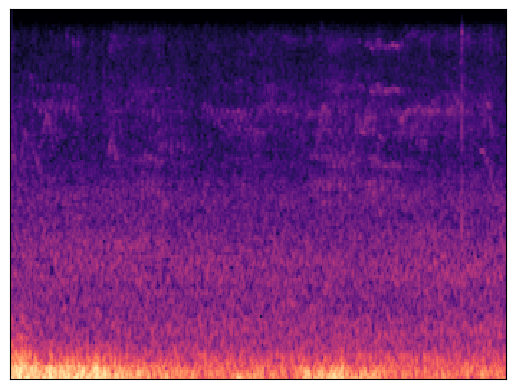

In [ ]:
#select randomly the index of an
i = random.choice(list(np.where(Y == 1)[0]))
# print(i)
# i =142
print(Y[i])

librosa.display.specshow(convert_to_spec(X[i]), sr=fs)

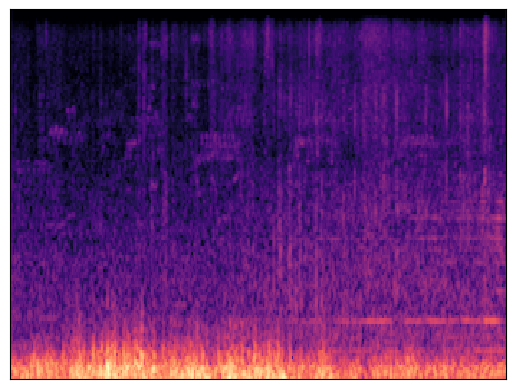

In [ ]:
librosa.display.specshow(Xs[i], sr=fs)

In [ ]:
unique, counts = np.unique(Y, return_counts=True)
original_distribution = dict(zip(unique, counts))
print('Data distribution:',original_distribution)

Data distribution: {0: 341, 1: 679}


#### Dataset

In [ ]:
# # #Dataset
absence_index = list(np.where(Y==0)[0])
presence_index = list(np.where(Y==1)[0])
augmented_X1, augmented_Y1 = augmented_data(Xs[absence_index,:], Y[absence_index], 2)
augmented_X2, augmented_Y2 = augmented_data(Xs[presence_index,:], Y[presence_index], 1)

In [ ]:

augmented_X = np.concatenate((augmented_X1, augmented_X2))
augmented_Y = np.concatenate((augmented_Y1, augmented_Y2))
# augmented_X = Xs
# augmented_Y = Y

In [ ]:
del X, Xs, Y, augmented_X1, augmented_Y1,augmented_X2, augmented_Y2

In [ ]:
unique, counts = np.unique(augmented_Y, return_counts=True)
original_distribution = dict(zip(unique, counts))
print('Data distribution:',original_distribution)

Data distribution: {0: 682, 1: 679}


In [ ]:
print(augmented_X.shape)
print(augmented_Y.shape)

(1361, 128, 345)
(1361,)


In [ ]:
#reshape augmented_X by adding one channel
augmented_X = augmented_X.reshape(augmented_X.shape[0],augmented_X.shape[1],augmented_X.shape[2], 1)

In [ ]:
#One-hot encoding
augmented_Y = to_categorical(augmented_Y)

In [ ]:
print(augmented_X.shape)
print(augmented_Y.shape)

(1361, 128, 345, 1)
(1361, 2)


In [ ]:
from sklearn.model_selection import train_test_split
seed = 123

X_train, X_val, Y_train, Y_val = train_test_split(augmented_X, augmented_Y,
            test_size=0.2, random_state=seed,
            shuffle=True)

In [ ]:
print(np.where(Y_val == [0, 1])[0].shape)
print(np.where(Y_val == [1, 0])[0].shape)

(268,)
(278,)


In [ ]:
del augmented_X, augmented_Y

In [ ]:
#Load testing files
#create testing data
with open('/content/drive/MyDrive/dl4e/Saved_Data/X_test.pkl','rb') as f:
  X_test=pickle.load(f)
with open('/content/drive/MyDrive/dl4e/Saved_Data/Y_test.pkl','rb') as f:
  Y_test=pickle.load(f)

In [ ]:
print(X_test.shape)
print(Y_test.shape)

(314, 128, 345)
(314,)


In [ ]:
X_test = convert_all_to_spec(X_test[:500])
#Item in Y are string
#Convert them into int
Y_test = np.array([int(y) for y in Y_test[:500]])
# print(Y.shape)

In [ ]:
#reshape X_test
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
#Encode Y_test
Y_test = to_categorical(Y_test)

In [ ]:
print(X_test.shape)
print(Y_test.shape)

(314, 128, 345, 1)
(314, 2)


In [ ]:
INPUT_SHAPE = (X_train.shape[1],X_train.shape[2], X_train[3])

# Model

### model 1

In [ ]:
#Create model
model = Sequential()
#Create some CNN layers
model.add(Conv2D(filters = 128,kernel_size=4, activation='relu',input_shape=INPUT_SHAPE))
model.add(MaxPool2D())
#Convert in vector
model.add(Flatten())
#Neural network
model.add(Dense(128, activation="relu"))
model.add(Dense(2, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 342, 128)     2176      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 171, 128)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1357056)           0         
                                                                 
 dense (Dense)               (None, 128)               173703296 
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 173705730 (662.63 MB)
Trainable params: 173705730 (662.63 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [ ]:
# with tf.device("/device:GPU:0"):
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
# history = model.fit(augmented_X,augmented_Y,validation_split=0.3,
#                     batch_size=256,epochs=5,shuffle=True)
history = model.fit(X_train,Y_train,
                      validation_data=(X_val, Y_val),
                      epochs=15,batch_size=128)

Epoch 1/15
9/9 [==============================] - 9s 436ms/step - loss: 9.3504 - accuracy: 0.4862 - val_loss: 1.1375 - val_accuracy: 0.4908
Epoch 2/15
9/9 [==============================] - 2s 269ms/step - loss: 1.2266 - accuracy: 0.5276 - val_loss: 0.8403 - val_accuracy: 0.4908
Epoch 3/15
9/9 [==============================] - 2s 279ms/step - loss: 0.7213 - accuracy: 0.5239 - val_loss: 0.6844 - val_accuracy: 0.5092
Epoch 4/15
9/9 [==============================] - 2s 257ms/step - loss: 0.6778 - accuracy: 0.5211 - val_loss: 0.6825 - val_accuracy: 0.4982
Epoch 5/15
9/9 [==============================] - 2s 259ms/step - loss: 0.6530 - accuracy: 0.6664 - val_loss: 0.6752 - val_accuracy: 0.5751
Epoch 6/15
9/9 [==============================] - 2s 258ms/step - loss: 0.5980 - accuracy: 0.6949 - val_loss: 0.6378 - val_accuracy: 0.6190
Epoch 7/15
9/9 [==============================] - 3s 284ms/step - loss: 0.5118 - accuracy: 0.8051 - val_loss: 0.6238 - val_accuracy: 0.6630
Epoch 8/15
9/9 [====

In [ ]:
model.evaluate(X_test, Y_test)

10/10 [==============================] - 1s 40ms/step - loss: 0.5169 - accuracy: 0.7038


[0.5168800950050354, 0.7038216590881348]

In [ ]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)  # Get predicted classes

16/16 [==============================] - 22s 1s/step


In [ ]:
with open("history_model_1.pkl", "wb") as f:
  pickle.dump({"history":history,"model":model}, f)

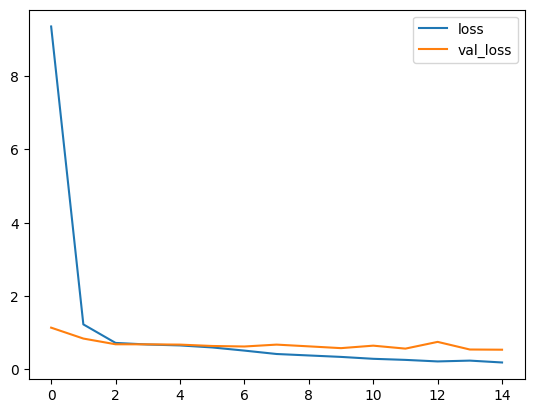

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()

In [ ]:
del history

### model 2

In [ ]:
X_train = np.concatenate((X_train, X_train, X_train), axis=-1)
X_val = np.concatenate((X_val, X_val, X_val), axis=-1)

In [ ]:
print(X_train.shape)

(1088, 128, 345, 3)


In [ ]:
INPUT_SHAPE = X_train.shape[1:]

In [ ]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam

In [ ]:
#Model 2
#We perfom here a transfert learning
base_model = ResNet50V2(weights="imagenet",
            input_shape=INPUT_SHAPE,
            include_top=False)#

94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

In [ ]:
# with tf.device("/device:GPU:0"):

# Create new model on top
inputs = Input(shape=INPUT_SHAPE)
x = base_model(inputs, training=False)
x = Flatten()(x)
outputs = Dense(2, activation='softmax')(x)
model = Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

filepath="{}_FineTuned.hdf5".format(seed)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 345, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 351, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 173, 64)          9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 66, 175, 64)          0         ['conv1_conv[0][0]']          
                                                                                         

In [ ]:
nbr_absence = len(absence_index)
nbr_presence = len(presence_index)
total = nbr_absence+nbr_presence

In [ ]:
weight_for_0 = (1 / nbr_absence) * (total / 2.0)
weight_for_1 = (1 / nbr_presence) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.50
Weight for class 1: 0.75


In [ ]:
history = model.fit(X_train,Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=2,
                    callbacks=callbacks_list,
                    class_weight=class_weight)

#base_model.trainable = True
model.summary()

Epoch 1/2
34/34 [==============================] - ETA: 0s - loss: 1.3806 - accuracy: 0.6572
Epoch 1: val_loss improved from inf to 0.83865, saving model to 123_FineTuned.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 142s 4s/step - loss: 1.3806 - accuracy: 0.6572 - val_loss: 0.8386 - val_accuracy: 0.6850
Epoch 2/2
34/34 [==============================] - ETA: 0s - loss: 0.4623 - accuracy: 0.8033
Epoch 2: val_loss improved from 0.83865 to 0.80989, saving model to 123_FineTuned.hdf5
34/34 [==============================] - 139s 4s/step - loss: 0.4623 - accuracy: 0.8033 - val_loss: 0.8099 - val_accuracy: 0.7582
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 345, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 4, 11, 2048)       23564800  
                                                                 
 flatten (Flatten)           (None, 90112)             0         
                                                                 
 dense (Dense)   

In [ ]:
model.compile(optimizer=Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=5,
                    callbacks=callbacks_list,
                    class_weight=class_weight)

Epoch 1/5
34/34 [==============================] - ETA: 0s - loss: 0.1651 - accuracy: 0.9366
Epoch 1: val_loss did not improve from 0.63907
34/34 [==============================] - 141s 4s/step - loss: 0.1651 - accuracy: 0.9366 - val_loss: 0.6577 - val_accuracy: 0.7106
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 0.1612 - accuracy: 0.9357
Epoch 2: val_loss did not improve from 0.63907
34/34 [==============================] - 138s 4s/step - loss: 0.1612 - accuracy: 0.9357 - val_loss: 0.6457 - val_accuracy: 0.7179
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.9403
Epoch 3: val_loss did not improve from 0.63907
34/34 [==============================] - 137s 4s/step - loss: 0.1594 - accuracy: 0.9403 - val_loss: 0.6546 - val_accuracy: 0.7143
Epoch 4/5
34/34 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.9393
Epoch 4: val_loss improved from 0.63907 to 0.63327, saving model to 123_FineTuned.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 140s 4s/step - loss: 0.1567 - accuracy: 0.9393 - val_loss: 0.6333 - val_accuracy: 0.7143
Epoch 5/5
34/34 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 0.9467
Epoch 5: val_loss did not improve from 0.63327
34/34 [==============================] - 137s 4s/step - loss: 0.1566 - accuracy: 0.9467 - val_loss: 0.6711 - val_accuracy: 0.7289


In [ ]:
model.load_weights('123_FineTuned.hdf5')

In [ ]:
X_test = np.concatenate((X_test, X_test, X_test), axis=-1)

In [ ]:
print(X_test.shape)

(314, 128, 345, 3)


In [ ]:
model.evaluate(X_test, Y_test)

10/10 [==============================] - 28s 3s/step - loss: 2.2958 - accuracy: 0.7675


[2.2958295345306396, 0.7675158977508545]

In [ ]:
# with open("history_2.pkl", "wb") as f:
#   pickle.dump({"history":history,"model":model2}, f)